# Breathing

In [1]:
import simpy
import numpy as np
import sys
from scipy import interpolate
from IPython.core.debugger import set_trace
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from virtualphysiology.organ.organ import OrganBase

# Periodic breathing: Cheyne-Stokes breathing

**Cheyne–Stokes respiration** (From Wikipedia, the free encyclopedia)

Cheyne–Stokes respiration is an abnormal pattern of breathing characterized by progressively deeper, and sometimes faster, breathing followed by a gradual decrease that results in a temporary stop in breathing called an apnea. The pattern repeats, with each cycle usually taking 30 seconds to 2 minutes.[1] It is an oscillation of ventilation between apnea and hyperpnea with a crescendo-diminuendo pattern, and is associated with changing serum partial pressures of oxygen and carbon dioxide.[2]

Cheyne–Stokes respiration and periodic breathing are the two regions on a spectrum of severity of oscillatory tidal volume. The distinction lies in what is observed at the trough of ventilation: Cheyne–Stokes respiration involves apnea (since apnea is a prominent feature in their original description) while periodic breathing involves hypopnea (abnormally small but not absent breaths).

These phenomena can occur during wakefulness or during sleep, where they are called the central sleep apnea syndrome (CSAS).[3]

It may be caused by damage to respiratory centers,[4] or by physiological abnormalities in congestive heart failure,[5] and is also seen in newborns with immature respiratory systems and in visitors new to high altitudes. One example is the breathing pattern in Joubert syndrome and related disorders.

## Mackey and Glass model

In [14]:
class P_CO2(OrganBase):
    
    def __init__(self, env, system, periodo = 1, max_delay=50):
        super().__init__( env, periodo, max_delay=max_delay)
        
        self.system=system
        self.state={
            'P_CO2':50,
            'rate':0,
            'rate_tot':0
            }
                
    def newState(self,state):
        
        h = state['periodo'] / 60 # para pasarlo a minutos
        time=state['time'] # Momento t-1
        
        rate_tot=state['rate']
        state['P_CO2'] = state['P_CO2'] + h * rate_tot     
        
        state['rate'] = 0 # Inicializo a cero
        state['rate_tot'] = rate_tot                 
            

In [15]:
class Tissue(OrganBase):
    
    def __init__(self, env, system, K, periodo = 1, max_delay=50):
        super().__init__( env, periodo, max_delay=max_delay)
        
        self.system=system
        self.state={
            'M': 170, # mmHg / min
            'K': K}
                        
    def newState(self,state):
        
        now=self.getTimeNow()
        
        rate = state['M'] / state['K'];
               
        state_pco2=self.system['P_CO2'].getState(now)
        x0 = state_pco2.get('rate',0)
        state_pco2['rate'] = x0 + rate
                    

In [16]:
class Lung(OrganBase):
    
    def __init__(self, env, system, periodo = 1, delay = 0, max_delay=50):
        super().__init__( env, periodo, max_delay=max_delay)
        
        #self.tissue = tissue
        self.delay = delay
        self.system = system
        
        self.state={
            'P_CO2_rate':0,
            'Gc': 2, # l/min/mmHg
            'P0' : 35,
            'Vp':30}
   
    def newState(self,state):
        
        now=self.getTimeNow()
        time=state['time'] # Momento t-1
                
        tissue = self.system['tissue'].getState(time)
        P_CO2=self.system['P_CO2'].getState(time)
        delay_PCO2 = self.system['P_CO2'].getState(time-self.delay)        
                        
        Vp = state['Gc'] * max( delay_PCO2['P_CO2'] - state['P0'] , 0)
        
        state['Vp'] = Vp
        rate  = - Vp * P_CO2['P_CO2'] / tissue['K'];
                
        p_CO2=self.system['P_CO2']
        
        state_pco2=self.system['P_CO2'].getState(now)
        x0 = state_pco2.get('rate',0)
        state_pco2['rate'] = x0 + rate 
                            

In [17]:
class Monitor(OrganBase):
    
    def __init__(self, env, system, periodo = 1, max_delay=50):
        super().__init__( env, periodo, max_delay=max_delay)
        
        self.system=system
        self.state={
            'P_CO2':-1}
        
        #self.state['time']=0
        #self.state['periodo']=self.__periodo
        #self.x_t = [copy.copy(self.state) for t in range(0,self.__max_delay + 1)]
        #self.__pos = 0
               
    def newState(self,state):
        time=state['time'] # Momento t-1
        P_CO2=self.system['P_CO2'].getState(time)
        state['P_CO2'] = P_CO2['P_CO2']  
        

<class '__main__.Tissue'>  start at 0
<class '__main__.Lung'>  start at 0
<class '__main__.Tissue'>  start at 0
<class '__main__.Tissue'>  start at 0
<class '__main__.P_CO2'>  start at 0
<class '__main__.Monitor'>  start at 0


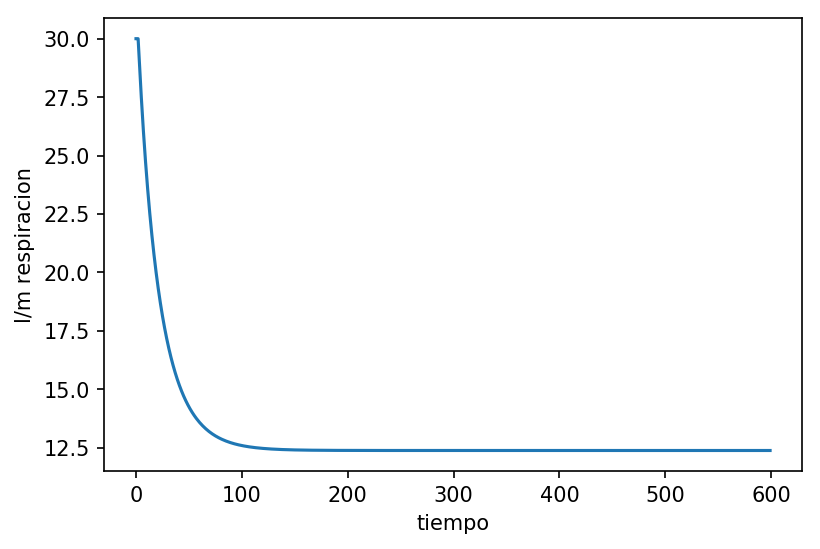

In [18]:
env = simpy.Environment()
system = {}

system['tissue'] = Tissue(env,system,K=39,periodo = 1)
system['lung'] = Lung(env,system,delay=0,periodo = 1)
system['tissue3'] = Tissue(env,system,K=39,periodo = 1)
system['tissue2'] = Tissue(env,system,K=39,periodo = 1)
system['P_CO2'] = P_CO2(env,system,periodo = 1)

monitor = Monitor(env,system,periodo = 1)
env.run(until=60*10)

df=system['lung'].getDataFrame()
plt.rcParams['figure.dpi'] = 150
plt.plot(df['Vp'])
plt.xlabel('tiempo')
plt.ylabel('l/m respiracion')
plt.show()

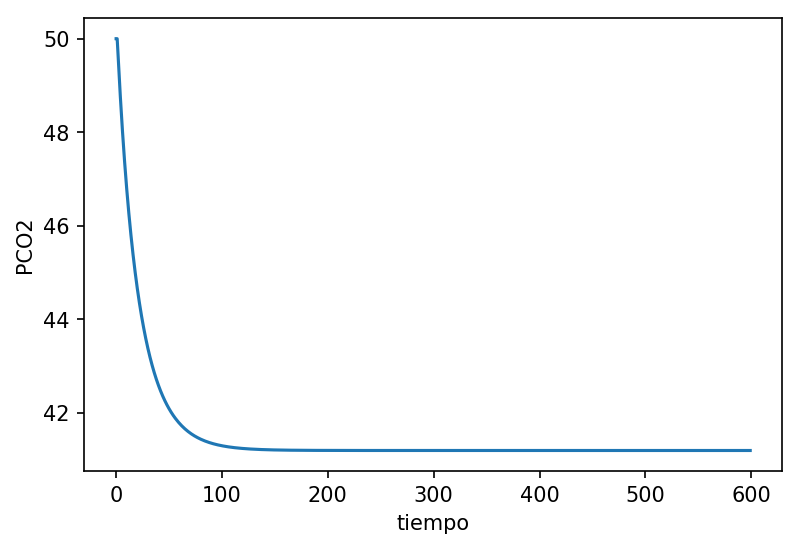

In [19]:
df=system['P_CO2'].getDataFrame()
plt.rcParams['figure.dpi'] = 150
plt.plot(df['P_CO2'])
plt.xlabel('tiempo')
plt.ylabel('PCO2')
plt.show()

<class '__main__.P_CO2'>  start at 0
<class '__main__.Tissue'>  start at 0
<class '__main__.Lung'>  start at 0
<class '__main__.Monitor'>  start at 0


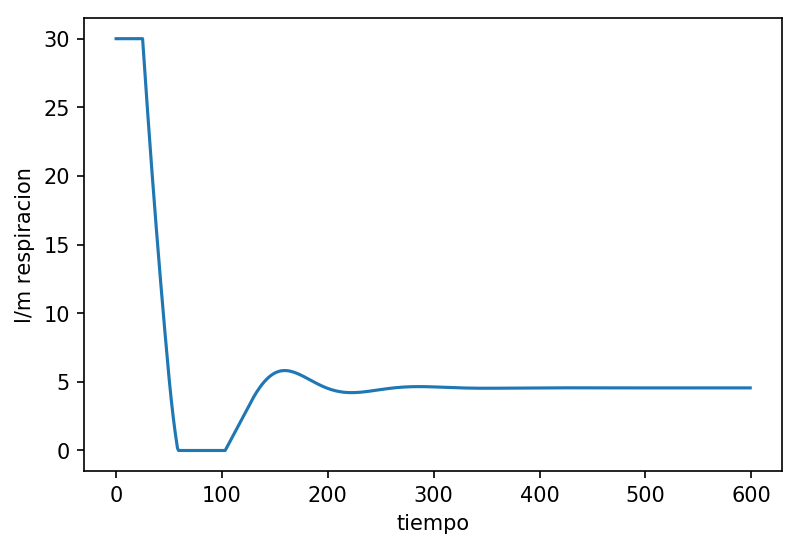

In [20]:
env = simpy.Environment()
system = {}

p_CO2 = P_CO2(env,system,periodo = 1)
tissue = Tissue(env,system,K=39,periodo = 1)
lung = Lung(env,system,delay=23,periodo = 1)
system['tissue']=tissue
system['lung']=lung
system['P_CO2']=p_CO2

monitor = Monitor(env,system,periodo = 1)
env.run(until=60*10)

df=lung.getDataFrame()
plt.rcParams['figure.dpi'] = 150
plt.plot(df['Vp'])
plt.xlabel('tiempo')
plt.ylabel('l/m respiracion')
plt.show()

<class '__main__.Tissue'>  start at 0
<class '__main__.Lung'>  start at 0
<class '__main__.P_CO2'>  start at 0
<class '__main__.Tissue'>  start at 0
<class '__main__.Tissue'>  start at 0
<class '__main__.Monitor'>  start at 0


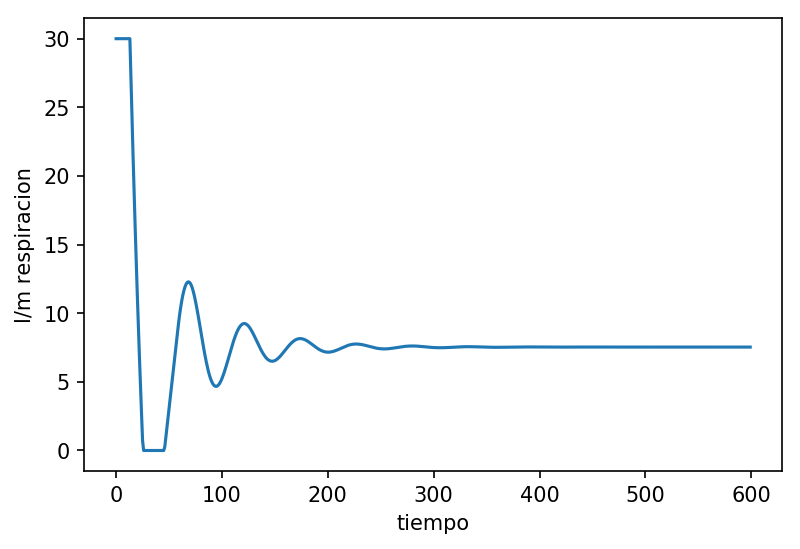

,Gc,P0,P_CO2_rate,Vp,periodo,time
595,2,35,0,7.533715,1,595
596,2,35,0,7.533720,1,596
597,2,35,0,7.533722,1,597
598,2,35,0,7.533721,1,598
599,2,35,0,7.533718,1,599


In [21]:
env = simpy.Environment()
system = {}

tissue = Tissue(env,system,K=14,periodo = 1)
lung = Lung(env,system,delay=11,periodo = 1)
p_CO2 = P_CO2(env,system,periodo = 1)
system['tissue']=tissue
system['lung']=lung
system['P_CO2']=p_CO2

system['tissue3'] = Tissue(env,system,K=39,periodo = 1)
system['tissue3'] = Tissue(env,system,K=39,periodo = 1)

monitor = Monitor(env,system,periodo = 1)
env.run(until=60*10)

df=lung.getDataFrame()
plt.rcParams['figure.dpi'] = 150
plt.plot(df['Vp'])
plt.xlabel('tiempo')
plt.ylabel('l/m respiracion')
plt.show()

lung.getDataFrame().tail()

<class '__main__.P_CO2'>  start at 0
<class '__main__.Tissue'>  start at 0
<class '__main__.Lung'>  start at 0
<class '__main__.Monitor'>  start at 0


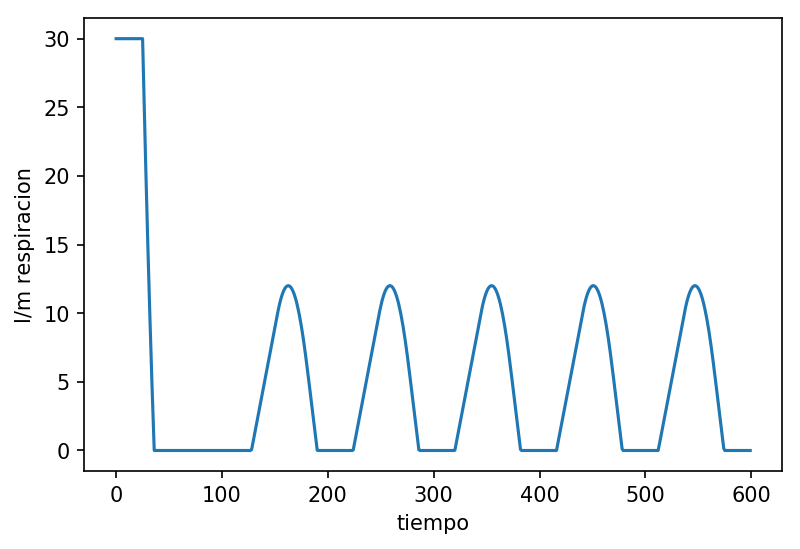

In [22]:
env = simpy.Environment()
system = {}

p_CO2 = P_CO2(env,system,periodo = 1)
tissue = Tissue(env,system,K=14,periodo = 1)
lung = Lung(env,system,delay=23,periodo = 1)
system['tissue']=tissue
system['lung']=lung
system['P_CO2']=p_CO2

monitor = Monitor(env,system,periodo = 1)
env.run(until=60*10)

df=lung.getDataFrame()
plt.rcParams['figure.dpi'] = 150
plt.plot(df['Vp'])
plt.xlabel('tiempo')
plt.ylabel('l/m respiracion')
plt.show()

<class '__main__.P_CO2'>  start at 0
<class '__main__.Tissue'>  start at 0
<class '__main__.Lung'>  start at 0
<class '__main__.Monitor'>  start at 0


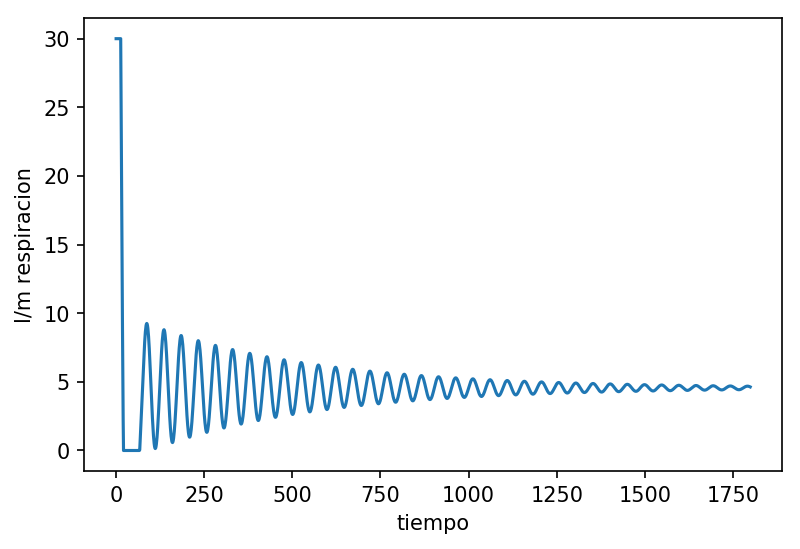

In [24]:

# NO SALE LO MISMO
env = simpy.Environment()
system = {}

p_CO2 = P_CO2(env,system,periodo = 1)
tissue = Tissue(env,system,K=10,periodo = 1)
lung = Lung(env,system,delay=11,periodo = 1)

system['tissue']=tissue
system['lung']=lung
system['P_CO2']=p_CO2

monitor = Monitor(env,system,periodo = 1)
env.run(until=60*30)

df=lung.getDataFrame()
plt.rcParams['figure.dpi'] = 150
plt.plot(df['Vp'])
plt.xlabel('tiempo')
plt.ylabel('l/m respiracion')
plt.show()